# Fraud Detection System 


In [5]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    classification_report,
    confusion_matrix
)

# Optional imports
try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_IMBLEARN = True
except Exception:
    HAS_IMBLEARN = False

import joblib


In [7]:
DATA_PATH = 'data/creditcard.csv'
RANDOM_STATE = 42

if os.path.exists(DATA_PATH):
    print(f"Loading dataset from {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)
else:
    print("No dataset found. Generating synthetic data...")
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=100000, n_features=30, n_informative=10, n_redundant=10,
                               weights=[0.998, 0.002], random_state=RANDOM_STATE)
    df = pd.DataFrame(X, columns=[f'V{i}' for i in range(1, 31)])
    df['Amount'] = np.abs(np.random.normal(50, 40, len(df)))
    df['Time'] = np.random.randint(0, 172800, len(df))
    df['Class'] = y

print(df.shape)
print(df['Class'].value_counts())


No dataset found. Generating synthetic data...
(100000, 33)
Class
0    99317
1      683
Name: count, dtype: int64


##  Exploratory Data Analysis

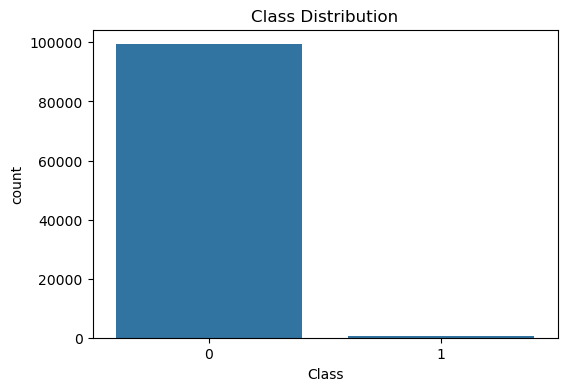

Fraud percentage: 0.6830%


In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

print(f"Fraud percentage: {df['Class'].mean() * 100:.4f}%")

##  Data Preprocessing

In [11]:
X = df.drop(columns=['Class'])
y = df['Class']

if X.isnull().sum().sum() > 0:
    X = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X), columns=X.columns)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, stratify=y_train_full, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [13]:
def evaluate_model(model, X_val, y_val):
    probs = model.predict_proba(X_val)[:, 1]
    preds = (probs >= 0.5).astype(int)
    roc = roc_auc_score(y_val, probs)
    precision, recall, _ = precision_recall_curve(y_val, probs)
    pr_auc = auc(recall, precision)
    print(f"ROC AUC: {roc:.4f} | PR AUC: {pr_auc:.4f}")
    print(classification_report(y_val, preds, digits=4))
    sns.heatmap(confusion_matrix(y_val, preds), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return {'roc_auc': roc, 'pr_auc': pr_auc}


##  Train Logistic Regression

ROC AUC: 0.6180 | PR AUC: 0.1116
              precision    recall  f1-score   support

           0     0.9950    0.6282    0.7702      7945
           1     0.0101    0.5455    0.0197        55

    accuracy                         0.6276      8000
   macro avg     0.5025    0.5868    0.3949      8000
weighted avg     0.9882    0.6276    0.7650      8000



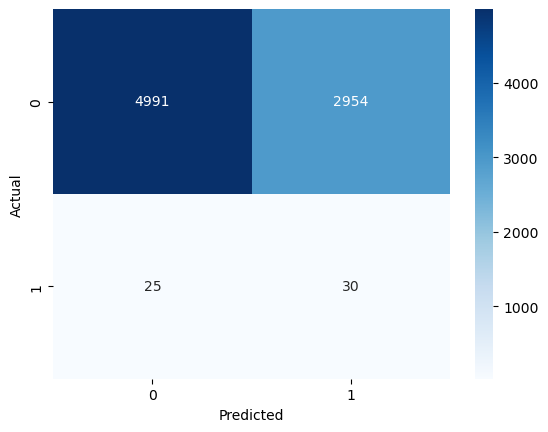

In [15]:
clf_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
clf_lr.fit(X_train_scaled, y_train)
eval_lr = evaluate_model(clf_lr, X_val_scaled, y_val)

## Train Random Forest

ROC AUC: 0.5820 | PR AUC: 0.1824
              precision    recall  f1-score   support

           0     0.9935    1.0000    0.9967      7945
           1     1.0000    0.0545    0.1034        55

    accuracy                         0.9935      8000
   macro avg     0.9967    0.5273    0.5501      8000
weighted avg     0.9935    0.9935    0.9906      8000



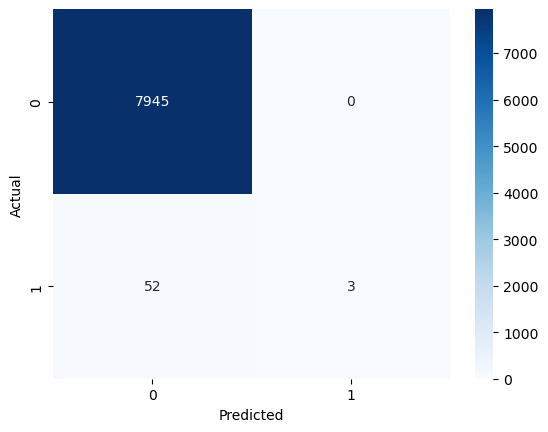

In [17]:
clf_rf = RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample', random_state=RANDOM_STATE, n_jobs=-1)
clf_rf.fit(X_train_scaled, y_train)
eval_rf = evaluate_model(clf_rf, X_val_scaled, y_val)

##  Train XGBoost 

ROC AUC: 0.6084 | PR AUC: 0.1745
              precision    recall  f1-score   support

           0     0.9940    1.0000    0.9970      7945
           1     1.0000    0.1273    0.2258        55

    accuracy                         0.9940      8000
   macro avg     0.9970    0.5636    0.6114      8000
weighted avg     0.9940    0.9940    0.9917      8000



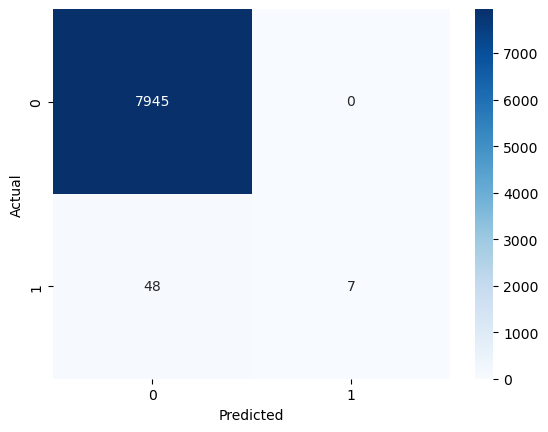

In [19]:
if HAS_XGB:
    clf_xgb = xgb.XGBClassifier(n_estimators=200, eval_metric='logloss', random_state=RANDOM_STATE)
    clf_xgb.fit(X_train_scaled, y_train)
    eval_xgb = evaluate_model(clf_xgb, X_val_scaled, y_val)
else:
    print('XGBoost not installed.')

##  SMOTE Resampling

In [21]:
if HAS_IMBLEARN:
    smote = SMOTE(sampling_strategy=0.05, random_state=RANDOM_STATE)
    under = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)
    rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    pipe = ImbPipeline(steps=[('smote', smote), ('under', under), ('rf', rf)])
    pipe.fit(X_train_scaled, y_train)
    probs = pipe.predict_proba(X_val_scaled)[:, 1]
    roc = roc_auc_score(y_val, probs)
    precision, recall, _ = precision_recall_curve(y_val, probs)
    pr_auc = auc(recall, precision)
    print(f"SMOTE RF | ROC AUC: {roc:.4f} | PR AUC: {pr_auc:.4f}")
else:
    print('imbalanced-learn not installed.')

SMOTE RF | ROC AUC: 0.6265 | PR AUC: 0.1832


##  Model Selection and Evaluation

In [23]:
results = [("LogReg", eval_lr['pr_auc'], clf_lr), ("RF", eval_rf['pr_auc'], clf_rf)]
if HAS_XGB:
    results.append(("XGB", eval_xgb['pr_auc'], clf_xgb))

best_name, best_score, best_model = sorted(results, key=lambda x: x[1], reverse=True)[0]
print(f"Best model: {best_name} (PR AUC={best_score:.4f})")

Best model: RF (PR AUC=0.1824)


ROC AUC: 0.6449 | PR AUC: 0.1924
              precision    recall  f1-score   support

           0     0.9934    1.0000    0.9967     19863
           1     1.0000    0.0438    0.0839       137

    accuracy                         0.9935     20000
   macro avg     0.9967    0.5219    0.5403     20000
weighted avg     0.9935    0.9935    0.9905     20000



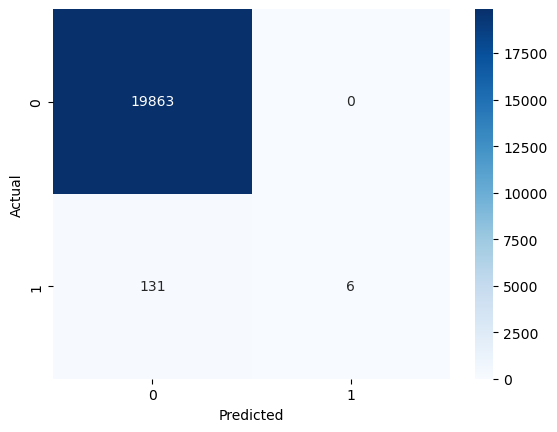

In [24]:
final_eval = evaluate_model(best_model, X_test_scaled, y_test)

##  Save Model and Predict

In [26]:
os.makedirs('models', exist_ok=True)
joblib.dump(best_model, 'models/best_model.joblib')
joblib.dump(scaler, 'models/scaler.joblib')
print('Saved model and scaler to models/')

Saved model and scaler to models/


In [27]:
def predict_transactions(df_raw, model_path='models/best_model.joblib', scaler_path='models/scaler.joblib', threshold=0.5):
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    df_scaled = scaler.transform(df_raw)
    probs = model.predict_proba(df_scaled)[:, 1]
    preds = (probs >= threshold).astype(int)
    return pd.DataFrame({'probability_fraud': probs, 'predicted_label': preds})

print(predict_transactions(X_test.iloc[:5]))

   probability_fraud  predicted_label
0              0.025                0
1              0.005                0
2              0.000                0
3              0.000                0
4              0.005                0
